In [10]:
!pip freeze

absl-py==1.4.0
accelerate==1.12.0
access==1.1.9
affine==2.4.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.2
aiosignal==1.4.0
aiosqlite==0.21.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.17.2
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.11.0
anywidget==0.9.21
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.3
arrow==1.4.0
arviz==0.22.0
astropy==7.1.1
astropy-iers-data==0.2025.11.24.0.39.11
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.1.0
Authlib==1.6.5
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.22.6
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.29.1
bigquery-magics==0.10.3
bleach==6.3.0
blinker==1.9.0
blis==1.3.3
blobfile==3.1.0
blosc2==3.11.1
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.2
brotli==1.2.0
CacheControl==0.14.4
cachetools==6.2.2
catalogue==2.0.10
certifi==2025.11.12
cffi==2.0.0
chardet==5.2.0
charset-normalizer==3.4.4
chex=

In [11]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import os
from matplotlib import pyplot as plt
import matplotlib

#matplotlibの背景を透明にする
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['figure.facecolor'] = 'none'

def read_csv(filename):
  df = pd.read_csv(filename,header=None, names=["concentration", "year", "month", "day", "hour", "minute", "second"])
  df["datetime"] = pd.to_datetime(df[["year", "month", "day", "hour", "minute", "second"]])
  df["elapsed_sec"] = (df["datetime"] - df["datetime"].min()).dt.total_seconds()
  df["elapsed_min"] = df["elapsed_sec"] / 60
  df = df.drop(columns=["year", "month", "day", "hour", "minute", "second"])
  return df

def calculate_slope(df, start, end):
  df = df[(df["elapsed_min"] >= start) & (df["elapsed_min"] <= end)]
  model = LinearRegression()
  model.fit(df[["elapsed_min"]], df["concentration"])
  return model.coef_[0], model.intercept_

def plot_and_get_slope(df, start, end, ax):
  df_before = df[df["elapsed_min"] < start]
  df_after = df[df["elapsed_min"] > end]
  df_middle = df[(df["elapsed_min"] >= start) & (df["elapsed_min"] <= end)]
  ax.plot(df_middle["elapsed_min"], df_middle["concentration"], label=f"{start}-{end}", color="tab:orange")
  ax.plot(df_before["elapsed_min"], df_before["concentration"], label=f"<{start}", color="tab:gray")
  ax.plot(df_after["elapsed_min"], df_after["concentration"], label=f">{end}", color="tab:gray")
  slope, intercept = calculate_slope(df, start, end)
  ax.plot(df["elapsed_min"], slope * df["elapsed_min"] + intercept, linestyle="dotted")
  return slope

def plot_and_calculate_all_csv(spans_name=None):
  if spans_name is None:
    spans = {}
  else:
    spans = pd.read_csv(spans_name).to_dict(orient='index')

  filenames = os.listdir()
  csv_files = [filename for filename in filenames if filename.endswith(".csv")]
  csv_files.sort()
  ncol = 4
  if len(csv_files) % ncol == 0:
    nrow = len(csv_files) // ncol
  else:
    nrow = len(csv_files) // ncol + 1
  fig, axes = plt.subplots(nrow, ncol, figsize=(4*ncol, 4*nrow), squeeze=False, sharex=False, sharey=False)

  slopes = []
  i_row = 0
  i_col = 0
  for filename in csv_files:
    df = read_csv(filename)
    span = spans.get(filename, {"start": 30, "end": 90})
    slope = plot_and_get_slope(df, span["start"], span["end"], axes[i_row, i_col])
    axes[i_row, i_col].set_title(filename.split(".")[0])
    i_col += 1
    if i_col == ncol:
      i_col = 0
      i_row += 1
    slopes.append([filename, slope])
  return pd.DataFrame(slopes, columns=["filename", "slope"])
def plot_correlation(df, x_ax, y_ax, x_name=None, y_name=None, ax=None):
  self_object = True
  if ax is None:
    self_object = False
    fig, ax = plt.subplots()
  ax.scatter(df[x_ax], df[y_ax])
  if x_name is None:
    x_name = x_ax
  if y_name is None:
    y_name = y_ax
  ax.set_xlabel(x_name)
  ax.set_ylabel(y_name)
  if self_object:
    return ax
  else:
    fig.show()

import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats

def linearRegression_with_confidence_prediction_intervals(x, y, alpha=0.05):
    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y)
    n = len(x)
    mean_x = np.mean(x)

    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)

    residuals = y - y_pred
    s_err = np.sqrt(np.sum(residuals**2) / (n - 2))
    t_value = stats.t.ppf(1 - alpha / 2, df=n - 2)

    se_line = s_err * np.sqrt(
        1/n + (x.flatten() - mean_x)**2 / np.sum((x.flatten() - mean_x)**2)
    )
    ci_upper = y_pred + t_value * se_line
    ci_lower = y_pred - t_value * se_line

    se_pred = s_err * np.sqrt(
        1 + 1/n + (x.flatten() - mean_x)**2 / np.sum((x.flatten() - mean_x)**2)
    )
    pi_upper = y_pred + t_value * se_pred
    pi_lower = y_pred - t_value * se_pred

    df_results = pd.DataFrame(
      {
        "x": x.ravel(),
        "y": y,
        "predicted": y_pred,
        "ci_lower": ci_lower,
        "ci_upper": ci_upper,
        "pi_lower": pi_lower,
        "pi_upper": pi_upper
      }
    )
    df_results = df_results.sort_values("x")
    return df_results

def plot_linear_regression(df_results, x_name=None, y_name=None, ax=None):
  if ax is None:
    fig, ax = plt.subplots()
  ax.plot(df_results.x, df_results.pi_lower, color="lightgray", linestyle=":")
  ax.plot(df_results.x, df_results.pi_upper, color="lightgray", linestyle=":")
  ax.plot(df_results.x, df_results.predicted, color="darkgray", linestyle="-")
  ax.plot(df_results.x, df_results.ci_lower, color="lightgray", linestyle="--")
  ax.plot(df_results.x, df_results.ci_upper, color="lightgray", linestyle="--")
  ax.fill_between(df_results.x, df_results.pi_lower, df_results.pi_upper, color="lightgray", alpha=0.5)
  ax.fill_between(df_results.x, df_results.ci_lower, df_results.ci_upper, color="darkgray", alpha=0.5)
  ax.scatter(df_results.x, df_results.y, zorder=10)
  if x_name is not None:
    ax.set_xlabel(x_name)
  if y_name is not None:
    ax.set_ylabel(y_name)

In [29]:
cd /content/

/content


In [3]:
!mkdir ./outputs

In [33]:
!unzip "Data1 (CO2 Conc. and colony weight).zip"

Archive:  Data1 (CO2 Conc. and colony weight).zip
   creating: Data1 (CO2 Conc. and colony weight)/
  inflating: Data1 (CO2 Conc. and colony weight)/H_20230918.csv  
  inflating: Data1 (CO2 Conc. and colony weight)/I_20230918.csv  
  inflating: Data1 (CO2 Conc. and colony weight)/J_20241114.csv  
  inflating: Data1 (CO2 Conc. and colony weight)/K_20241114.csv  
  inflating: Data1 (CO2 Conc. and colony weight)/L_20241114.csv  
  inflating: Data1 (CO2 Conc. and colony weight)/M_20241114_lower.csv  
  inflating: Data1 (CO2 Conc. and colony weight)/M_20241114_upper.csv  
  inflating: Data1 (CO2 Conc. and colony weight)/N_20241114.csv  
  inflating: Data1 (CO2 Conc. and colony weight)/O_20241114.csv  
  inflating: Data1 (CO2 Conc. and colony weight)/P_20241114.csv  
  inflating: Data1 (CO2 Conc. and colony weight)/Q_20241114.csv  
  inflating: Data1 (CO2 Conc. and colony weight)/R_20241114.csv  
  inflating: Data1 (CO2 Conc. and colony weight)/S_20241114.csv  
  inflating: Data1 (CO2 Conc. 

In [34]:
cd "Data1 (CO2 Conc. and colony weight)"

/content/Data1 (CO2 Conc. and colony weight)


# load all csv

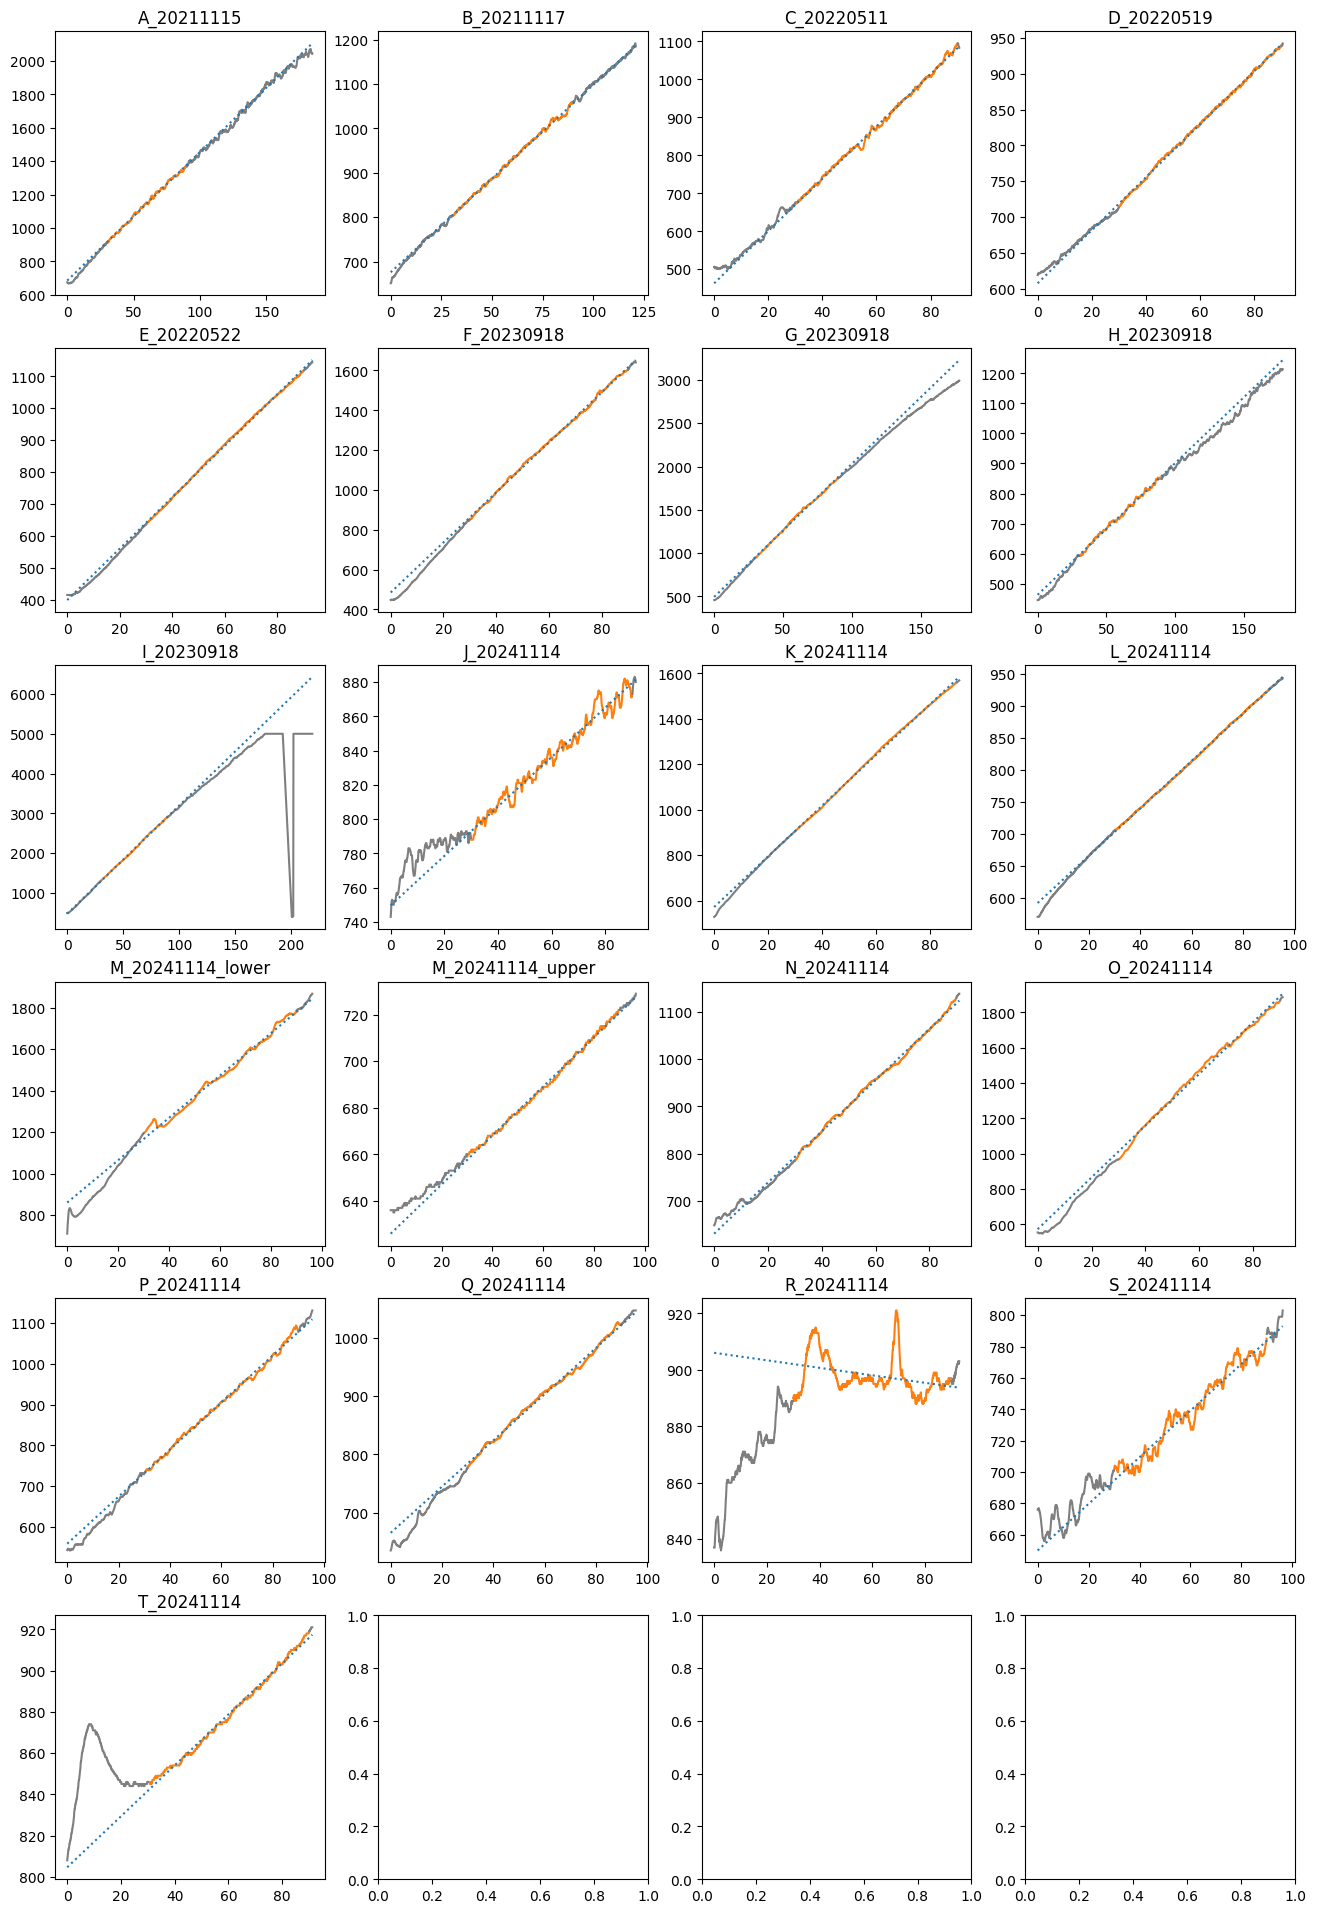

In [35]:
df_slopes = plot_and_calculate_all_csv()

# Figure 1B 全部重ねる

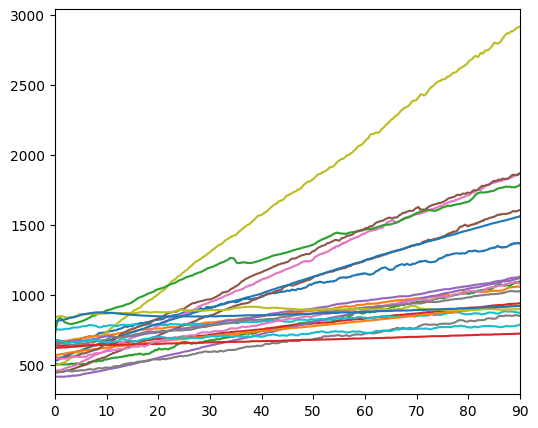

In [36]:
filenames = os.listdir()
csv_files = [filename for filename in filenames if filename.endswith(".csv")]
csv_files.sort()

fig, ax = plt.subplots(figsize=(6, 5))
for filename in csv_files:
  df = read_csv(filename)
  df = df[(df["elapsed_min"] >= 0) & (df["elapsed_min"] <= 90)]
  ax.plot(df["elapsed_min"], df["concentration"])
ax.set_xlim(0, 90)
fig.show()
fig.savefig("../outputs/figure1b.svg")

# Figre 1C Jを採用

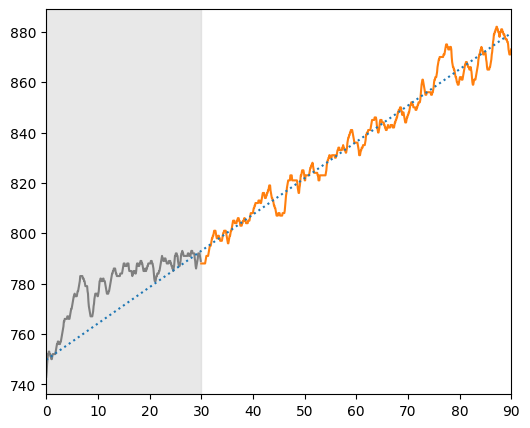

In [37]:
filename = "J_20241114.csv"
df = read_csv(filename)
df = df[(df["elapsed_min"] >= 0) & (df["elapsed_min"] <= 90)]

fig, ax = plt.subplots(figsize=(6, 5))
plot_and_get_slope(df, 30, 90, ax)
#x=0からx=30を塗りつぶす
ax.axvspan(0, 30, color="lightgray", alpha=0.5)
ax.set_xlim(0, 90)
fig.show()
fig.savefig("../outputs/figure1c.svg")

# Plot correlations

In [38]:
df_slopes["colony"] = df_slopes["filename"].apply(lambda x: x.split("_")[0])
df_slopes = df_slopes.groupby("colony").sum().drop(columns="filename")

In [39]:
df_weight = pd.read_excel("termite_weight.xlsx")
df_slopes = pd.merge(df_slopes, df_weight, left_index=True, right_on="colony")

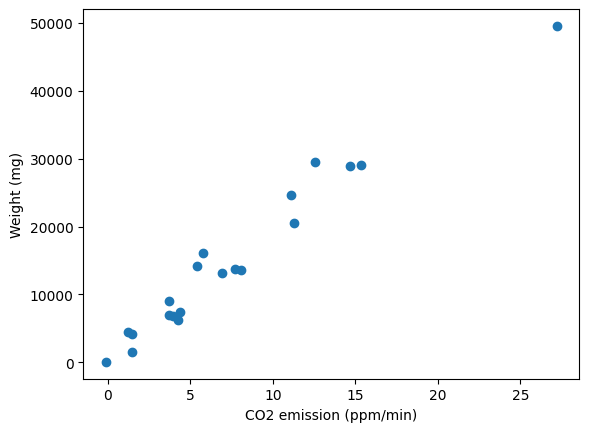

In [40]:
plot_correlation(df_slopes, "slope", "weight", "CO2 emission (ppm/min)", "Weight (mg)")

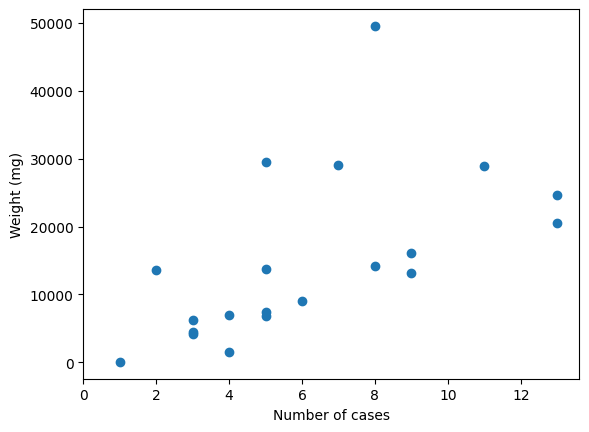

In [41]:
fig, ax = plt.subplots()
plot_correlation(df_slopes, "plate_num", "weight", "Number of cases", "Weight (mg)", ax)
ax.set_xlim(0, )
fig.show()

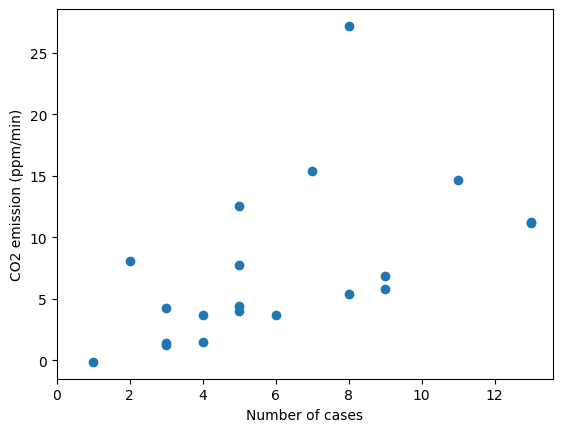

In [42]:
fig, ax = plt.subplots()
plot_correlation(df_slopes, "plate_num", "slope", "Number of cases", "CO2 emission (ppm/min)", ax)
ax.set_xlim(0, )
fig.show()

# 回帰分析 (Figure 2)

In [43]:
from sklearn.linear_model import LinearRegression

## CO2 and weight (Figure 2a)

In [44]:
volume = 20400 #The volume of the container(mL)
df_slopes["emission"] = df_slopes["slope"] * volume / 1000000

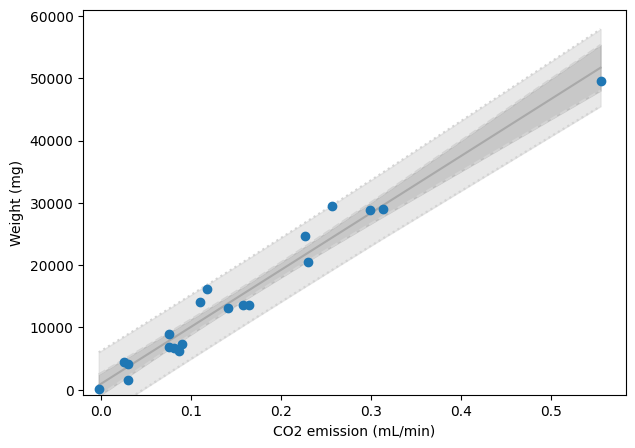

In [45]:
x = df_slopes.emission
y = df_slopes.weight
df_results = linearRegression_with_confidence_prediction_intervals(x, y, alpha=0.05)
fig, ax = plt.subplots(figsize=(7, 5))
plot_linear_regression(df_results, "CO2 emission (mL/min)", "Weight (mg)", ax=ax)
ax.set_xlim(-0.02, )
ax.set_ylim(-800, )
fig.show()
fig.savefig("../outputs/figure2a.svg")

In [46]:
# 係数を取得
model = LinearRegression()
model.fit(x.values.reshape(-1, 1), y)

coef = model.coef_[0]
intercept = model.intercept_

print(f"y = {coef:.3f} * x + {intercept:.3f}")

R2 = model.score(x.values.reshape(-1, 1), y)
print(f"R2 = {R2:.3f}")

r = np.corrcoef(x, y)[0, 1]
print(f"r = {r:.3f}")

y = 91505.337 * x + 969.489
R2 = 0.965
r = 0.982


## Number of case and weight (Figure 2b)

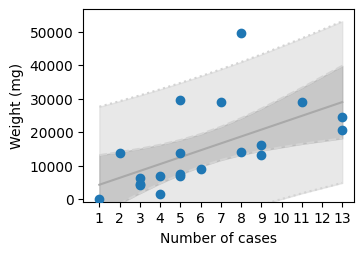

In [47]:
x = df_slopes.plate_num
y = df_slopes.weight
df_results = linearRegression_with_confidence_prediction_intervals(x, y, alpha=0.05)
fig, ax = plt.subplots(figsize=(3.5, 2.5))
plot_linear_regression(df_results, "Number of cases", "Weight (mg)", ax=ax)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xlim(0.2, )
ax.set_ylim(-800)
fig.show()
fig.savefig("../outputs/figure2b.svg")

## Number of cases and CO2 emission (Figure 2c)

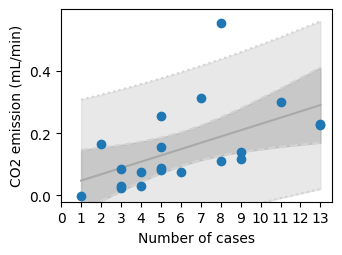

In [48]:
x = df_slopes.plate_num
y = df_slopes.emission
df_results = linearRegression_with_confidence_prediction_intervals(x, y, alpha=0.05)
fig, ax = plt.subplots(figsize=(3.5, 2.5))
plot_linear_regression(df_results, "Number of cases", "CO2 emission (mL/min)", ax=ax)
#xの軸目盛りを整数のみに
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xlim(0, )
ax.set_ylim(-0.02)
fig.show()
fig.savefig("../outputs/figure2c.svg")

# 相関の検定

In [49]:
df_slopes = df_slopes.set_index("colony")

In [50]:
#相関係数
df_slopes.corr()

,slope,weight,plate_num,emission
slope,1.000000,0.982153,0.532796,1.000000
weight,0.982153,1.000000,0.581660,0.982153
plate_num,0.532796,0.581660,1.000000,0.532796
emission,1.000000,0.982153,0.532796,1.000000


In [51]:
df_slopes.corr() ** 2

,slope,weight,plate_num,emission
slope,1.000000,0.964625,0.283871,1.000000
weight,0.964625,1.000000,0.338329,0.964625
plate_num,0.283871,0.338329,1.000000,0.283871
emission,1.000000,0.964625,0.283871,1.000000


In [52]:
from scipy.stats import t as t_dist
def isCorrelationDifferent(df, factorA, factorX, factorY):
  n = len(df)
  A = df[factorA]
  X = df[factorX]
  Y = df[factorY]
  rAX = A.corr(X)
  rAY = A.corr(Y)
  rXY = X.corr(Y)

  numerator = rAX - rAY
  denominator = ((1 - rAX**2 - rAY**2 - rXY**2 + 2 * rAX * rAY * rXY) / (n - 3)) * ((1 + rXY) / 2)

  if denominator <= 0:
      raise ValueError("分母が0以下になりました。相関係数の組み合わせまたはサンプルサイズを確認してください。")

  t = numerator / np.sqrt(denominator)
  p = 2 * t_dist.sf(np.abs(t), df=n-3)  # 両側検定

  print(f"自由度：{n-3}\nt値：{t}\np値：{p}")
  return t, p

In [53]:
t, p = isCorrelationDifferent(df_slopes, "weight", "slope", "plate_num")

自由度：17
t値：12.738463164396714
p値：4.01452842689375e-10


# 侵襲性のテスト

In [55]:
cd /content

/content


In [56]:
!unzip "Data2 (Repeated measurements to assess invasiveness).zip"

Archive:  Data2 (Repeated measurements to assess invasiveness).zip
   creating: Data2 (Repeated measurements to assess invasiveness)/
  inflating: Data2 (Repeated measurements to assess invasiveness)/1_20220924.csv  
  inflating: Data2 (Repeated measurements to assess invasiveness)/1_20220926.csv  
  inflating: Data2 (Repeated measurements to assess invasiveness)/1_20220928.csv  
  inflating: Data2 (Repeated measurements to assess invasiveness)/1_20220930.csv  
  inflating: Data2 (Repeated measurements to assess invasiveness)/2_20220924.csv  
  inflating: Data2 (Repeated measurements to assess invasiveness)/2_20220926.csv  
  inflating: Data2 (Repeated measurements to assess invasiveness)/2_20220928.csv  
  inflating: Data2 (Repeated measurements to assess invasiveness)/2_20220930.csv  
  inflating: Data2 (Repeated measurements to assess invasiveness)/3_20220924.csv  
  inflating: Data2 (Repeated measurements to assess invasiveness)/3_20220926.csv  
  inflating: Data2 (Repeated measure

In [57]:
cd /content/"Data2 (Repeated measurements to assess invasiveness)"/

/content/Data2 (Repeated measurements to assess invasiveness)


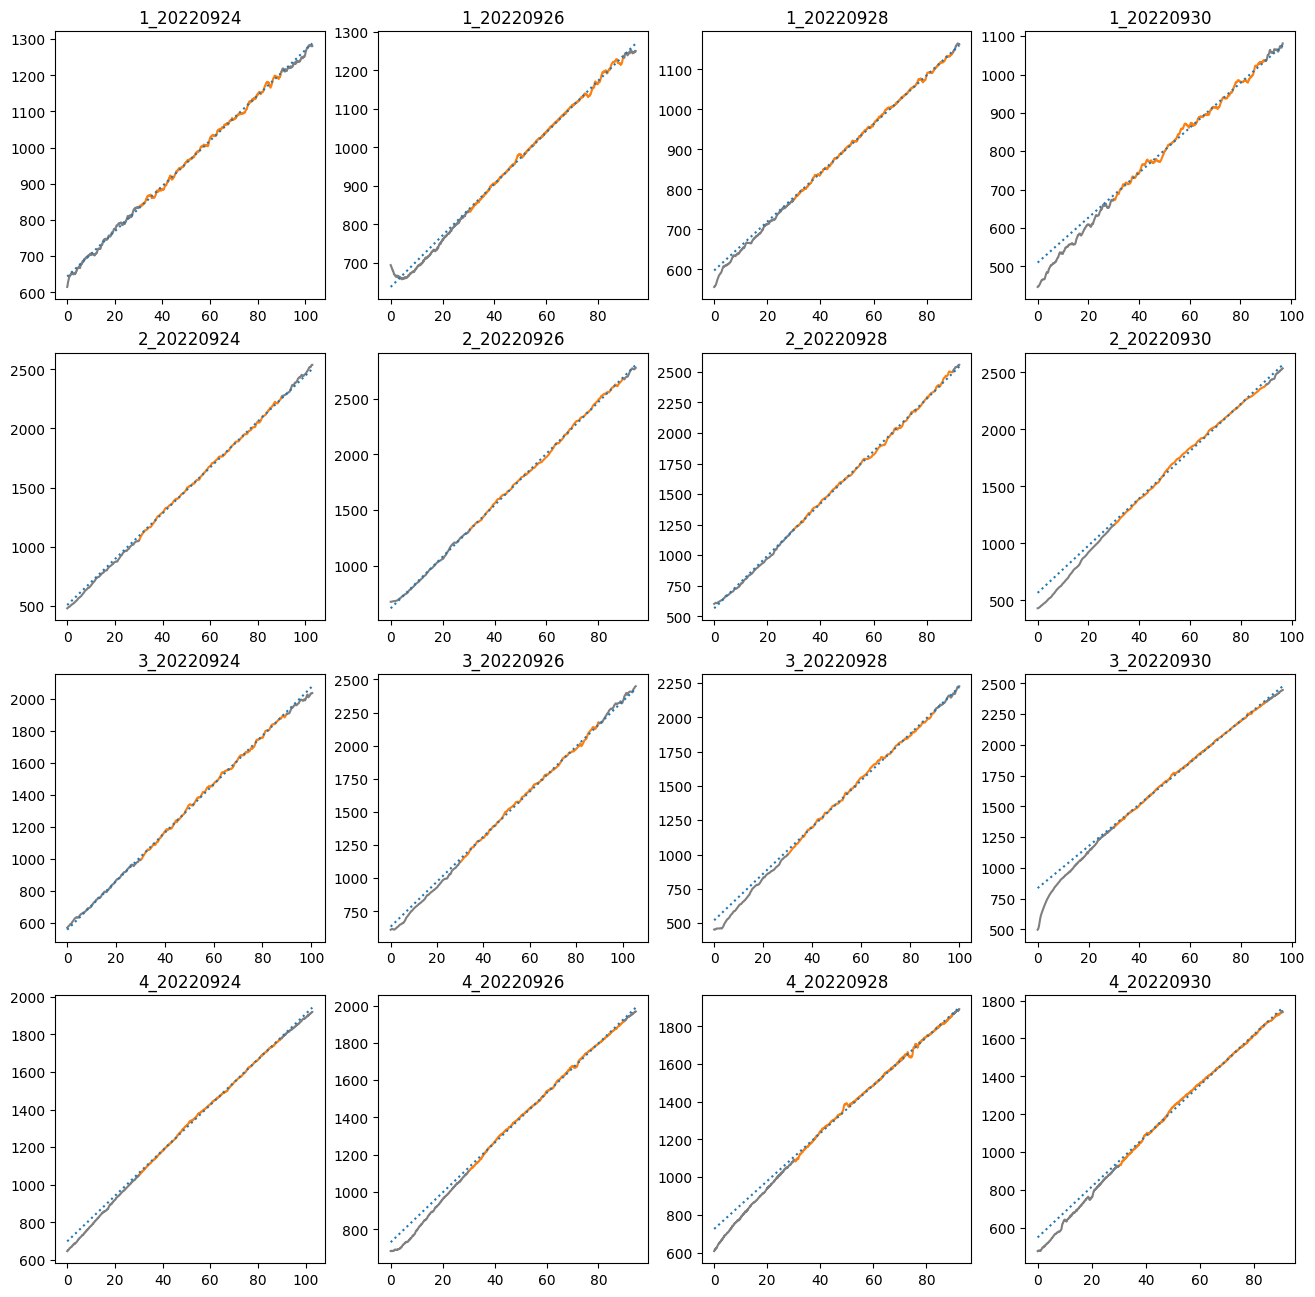

In [58]:
df_slopes = plot_and_calculate_all_csv()

In [59]:
df_slopes[["colony", "date_str"]] = df_slopes['filename'].str.split('_', n=1, expand=True)
df_slopes['date_str'] = df_slopes['date_str'].str.replace('.csv', '', regex=False).astype(str)
#df_slopes["date"] = pd.to_datetime(df_slopes["date_str"])
df_slopes["colony"] = df_slopes["colony"].astype(str)
unique_dates = sorted(df_slopes['date_str'].unique())
date_mapping = {date_str: i * 2 for i, date_str in enumerate(unique_dates)}
df_slopes['day'] = df_slopes['date_str'].map(date_mapping)

In [60]:
df_slopes["emission"] = df_slopes["slope"] * volume / 1000000
df_slopes["estimated"] = df_slopes.emission * coef + intercept

In [61]:
df_slopes

,filename,slope,colony,date_str,day,emission,estimated
0,1_20220924.csv,6.260158,1,20220924,0,0.127707,12655.382133
1,1_20220926.csv,6.695866,1,20220926,2,0.136596,13468.720835
2,1_20220928.csv,6.101585,1,20220928,4,0.124472,12359.371974
3,1_20220930.csv,5.858947,1,20220930,6,0.119523,11906.437361
4,2_20220924.csv,19.419378,2,20220924,0,0.396155,37219.814154
5,2_20220926.csv,23.165843,2,20220926,2,0.472583,44213.372689
6,2_20220928.csv,21.439867,2,20220928,4,0.437373,40991.478837
7,2_20220930.csv,20.754924,2,20220930,6,0.423400,39712.889664
8,3_20220924.csv,15.187054,3,20220924,0,0.309816,29319.297041
9,3_20220926.csv,17.000589,3,20220926,2,0.346812,32704.638452


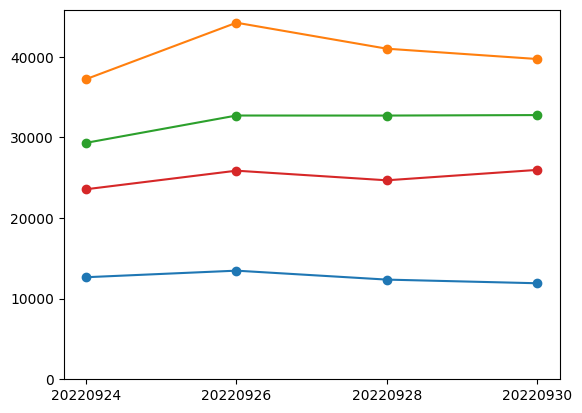

In [64]:
fig, ax = plt.subplots()
for key, df_colony in df_slopes.groupby("colony"):
  ax.plot(df_colony.date_str, df_colony.estimated, label=key)
  ax.scatter(df_colony.date_str, df_colony.estimated)
#ax.legend()
ax.set_ylim(0,)
fig.show()
fig.savefig("../outputs/time_series.svg")

## NHSTで有意でないことを確認。LMMでフィット、尤度比検定でモデル比較

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2

# --- 前処理 ---
# df_slopes: columns = ['slope'(float), 'colony'(str), 'date'(datetime64[ns] or date), 'date_str'(str)]
# 1) 日付を datetime64 に統一
df = df_slopes.copy()

# 2) 回帰可能な数値に変換（最小日からの経過日数）
df['date_num'] = df["day"].astype(int)

# （任意）スケーリングして収束性・解釈を改善
# 標準化した説明変数を使う場合は以下を使用（どちらか一方）
# df['date_scaled'] = (df['date_num'] - df['date_num'].mean()) / df['date_num'].std(ddof=0)

# 欠損の除去（必要に応じて）
df = df.loc[df[['slope', 'colony', 'date_num']].notna().all(axis=1)].copy()

# colony をカテゴリ化（推奨）
df['colony'] = df['colony'].astype('category')

# --- モデル当てはめ（REML=False にして LRT 可能な ML 推定） ---
# モデル1: slope ~ date_num + (1 | colony)
model1 = smf.mixedlm("slope ~ date_num", data=df, groups=df["colony"])
fit1 = model1.fit(reml=False, method='lbfgs', maxiter=200)

# モデル2（null）: slope ~ 1 + (1 | colony)
model0 = smf.mixedlm("slope ~ 1", data=df, groups=df["colony"])
fit0 = model0.fit(reml=False, method='lbfgs', maxiter=200)

# --- 尤度比検定（LRT） ---
ll1 = fit1.llf
ll0 = fit0.llf
# 自由度差：固定効果の差が1（dateの係数）※分散成分の構造が同じ前提
df_diff = fit1.params.size - fit0.params.size  # 形式上の差分
# 通常は 1 になるはずだが、保険として max(1, …)
df_diff = max(1, df_diff)

lr_stat = 2 * (ll1 - ll0)
p_value = chi2.sf(lr_stat, df_diff)

# --- 結果の表示 ---
print("=== Model 1 (with date) summary ===")
print(fit1.summary())
print("\n=== Model 2 (null) summary ===")
print(fit0.summary())

print("\n=== Likelihood Ratio Test (Model 1 vs Null) ===")
print(f"LogLik(Model1) = {ll1:.3f}")
print(f"LogLik(Model0) = {ll0:.3f}")
print(f"LR statistic   = {lr_stat:.3f}")
print(f"df             = {df_diff}")
print(f"p-value        = {p_value:.6g}")

# date の効果推定と95%信頼区間
params = fit1.params
conf   = fit1.conf_int()
print("\n=== Fixed effect: date_num ===")
print(f"coef = {params.get('date_num', np.nan):.6g}")
if 'date_num' in conf.index:
    print(f"95% CI = [{conf.loc['date_num', 0]:.6g}, {conf.loc['date_num', 1]:.6g}]")

=== Model 1 (with date) summary ===
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: slope   
No. Observations: 16      Method:             ML      
No. Groups:       4       Scale:              0.8495  
Min. group size:  4       Log-Likelihood:     -31.2949
Max. group size:  4       Converged:          Yes     
Mean group size:  4.0                                 
------------------------------------------------------
             Coef.  Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    13.869    2.753 5.038 0.000  8.473 19.265
date_num      0.115    0.103 1.119 0.263 -0.087  0.317
Group Var    29.722   26.517                          


=== Model 2 (null) summary ===
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: slope   
No. Observations: 16      Method:             ML      
No. Groups:       4       Scale:              0.9381  
Min. group siz

## 非劣性試験を行う

In [ ]:
import numpy as np
from scipy.stats import norm

# 1) 下ごしらえ：session番号(0,1,2,3)とlog応答
df_ni = df.copy()
order = {d: i for i, d in enumerate(sorted(df_ni['day'].unique()))}
df_ni['session'] = df_ni['day'].map(order)
if (df_ni['estimated'] <= 0).any():
    raise ValueError("estimated に 0 以下が含まれています。log変換前に除外/修正してください。")
df_ni['log_estimated'] = np.log(df_ni['estimated'])
df_ni['colony'] = df_ni['colony'].astype('category')

# 2) LMM（ログスケール、ランダム切片=colony）をMLで当てる
model = smf.mixedlm("log_estimated ~ session", data=df_ni, groups=df_ni["colony"])
res = model.fit(method="lbfgs", reml=False)

# 3) 非劣性判定：H0: β <= log(0.97) vs H1: β > log(0.97)
margin = 0.99
beta0 = np.log(margin)
beta_hat = res.params['session']
se_beta = res.bse['session']

z = (beta_hat - beta0) / se_beta                 # Wald z
p_one_sided = 1 - norm.cdf(z)                    # 片側p値（小さいほど非劣性を支持）

# 90%下側CI（expスケールでも報告）
z90 = norm.ppf(0.90)
beta_lower90 = beta_hat - z90 * se_beta
exp_beta = np.exp(beta_hat)
exp_beta_lower90 = np.exp(beta_lower90)

print(f"=== Non-inferiority (per-session margin = -{(1-margin)*100:1f}%; exp(beta) > {margin}) ===")
print(f"beta_hat = {beta_hat:.6f}  (SE = {se_beta:.6f})")
print(f"exp(beta_hat) = {exp_beta:.4f}")
print(f"90% lower CI for exp(beta) = {exp_beta_lower90:.4f}")
print(f"One-sided p-value (H0: beta <= log({margin})) = {p_one_sided:.4g}")

if exp_beta_lower90 > margin and p_one_sided < 0.05:
    print(f"=> Non-inferiority concluded: the lower 90% CI exceeds {margin} (alpha=0.05).")
else:
    print(f"=> Non-inferiority NOT concluded at alpha=0.05.")

=== Non-inferiority (per-session margin = -1.000000%; exp(beta) > 0.99) ===
beta_hat = 0.010648  (SE = 0.012318)
exp(beta_hat) = 1.0107
90% lower CI for exp(beta) = 0.9949
One-sided p-value (H0: beta <= log(0.99)) = 0.04645
=> Non-inferiority concluded: the lower 90% CI exceeds 0.99 (alpha=0.05).
